![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode

In [27]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [28]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [29]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [30]:
bikes.groupby('season')['total'].agg(['min', 'max', 'mean', 'std', 'median', 
                                      lambda x: np.percentile(x,25),
                                      lambda x: np.percentile(x,75)]).rename(
    columns={'<lambda_0>':'P25','<lambda_1>':'P75'})


,min,max,mean,std,median,P25,P75
season,,,,,,,
1,1,801,116.343261,125.273974,78.0,24.0,164.0
2,1,873,215.251372,192.007843,172.0,49.0,321.0
3,1,977,234.417124,197.151001,195.0,68.0,347.0
4,1,948,198.988296,177.622409,161.0,51.0,294.0


In [31]:
bikes.groupby('hour')['total'].agg(['min', 'max', 'mean', 'std', 'median',
                                    lambda x: np.percentile(x,25),
                                    lambda x: np.percentile(x,75)]).rename(
    columns={'<lambda_0>':'P25','<lambda_1>':'P75'})

,min,max,mean,std,median,P25,P75
hour,,,,,,,
0,2,283,55.138462,43.620012,41.0,24.00,74.50
1,1,168,33.859031,34.112105,19.0,11.00,46.00
2,1,119,22.899554,26.110267,11.0,5.00,32.00
3,1,66,11.757506,12.666442,6.0,3.00,15.00
4,1,28,6.407240,4.217633,6.0,3.00,9.00
5,1,57,19.767699,12.784293,19.0,8.00,29.00
6,1,213,76.259341,54.745333,75.0,24.50,118.00
7,1,596,213.116484,159.207044,208.0,63.00,334.00
8,8,839,362.769231,231.723065,392.0,133.50,563.50


Información del Diccionario:
1:winter, 2:spring, 3:summer, 4:fall.

La estación con mayor demanda es el Verano, con un promedio de 234.42 bicicletas alquiladas. En cambio la demanda más baja es el invierno, con tan solo 116.34. Seguramente se da por las condiciones climaticas.
Respecto a las horas con mayor demanda, se destacan entre las 17 y las 18, Y la segunda franja con mayor demanda es a las 8 am, en donde se pueden atribuir a la necesidad de transporte de horario matutinos.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

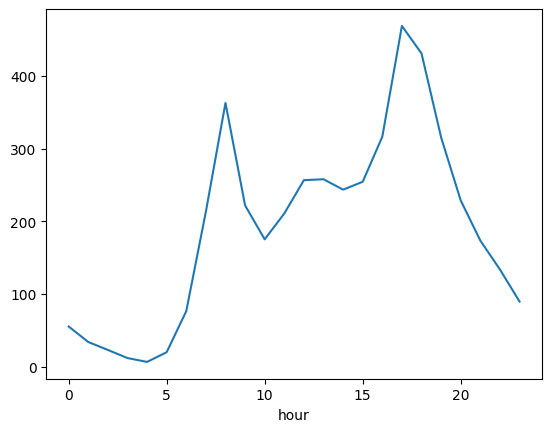

In [32]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: title={'center': 'Promedio de bicicletas rentadas por hora en Invierno'}, xlabel='Hora del día', ylabel='Promedio bicicletas rentadas'>

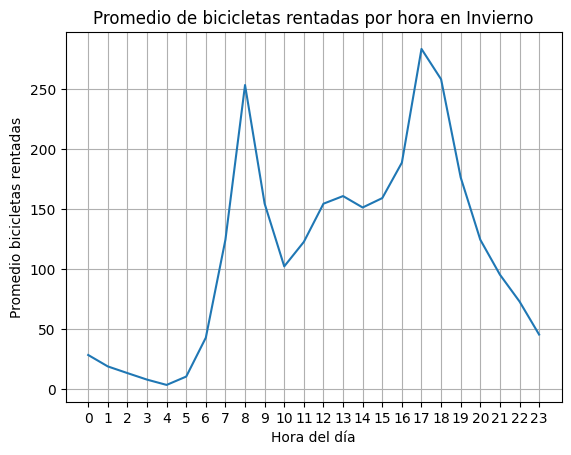

In [33]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour')['total'].mean().plot(
    title='Promedio de bicicletas rentadas por hora en Invierno',
    xlabel='Hora del día',
    ylabel='Promedio bicicletas rentadas',
    xticks=range(0,24),
    grid=True
)

<Axes: title={'center': 'Promedio de bicicletas rentadas por hora en Verano'}, xlabel='Hora del día', ylabel='Promedio bicicletas rentadas'>

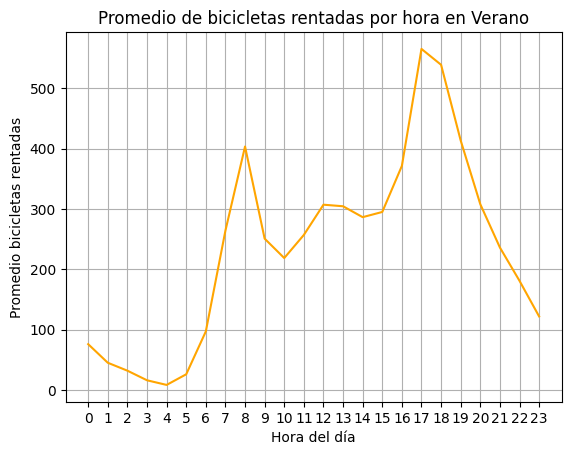

In [34]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour')['total'].mean().plot(
    title='Promedio de bicicletas rentadas por hora en Verano',
    xlabel='Hora del día',
    ylabel='Promedio bicicletas rentadas',
    xticks=range(0,24),
    grid=True,
    color='orange'
)

La tendencia de la demanda para ambas gráficas se similar, con una diferencia notable en el promedio de las biciclietas rentadas, siendo mayor demandado el servicio en el Verano. Esto puede darse porque el clima impacta en la decisión de las personas de alquilar una bicicleta y estar al aire libre. Básicamente el uso promedio de las bicicletas rentadas se dobla en Verano.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a un conjunto de train de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [35]:
# Celda 3 -- Creación de variables dummy para la variable categórica "season"
XL = pd.get_dummies(bikes[['season', 'hour']], columns=['season'], drop_first=True)
YL = bikes['total']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(XL, YL, test_size=0.3, random_state=42)

# Ajustar modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Imprimir coeficientes
coeficientes = pd.Series(lin_reg.coef_, index=XL.columns)
print("Intercepto:", lin_reg.intercept_)
print("Coeficientes:\n", coeficientes)

Intercepto: -8.187223101039052
Coeficientes:
 hour         10.727042
season_2     99.758492
season_3    115.078340
season_4     88.918206
dtype: float64


**Hallazgos alrededor del ejercicio**
Este modelo no puede capturar fácilmente patrones complejos o interacciones entre variables, por ejemplo, el efecto combinado de estación y hora, y es que según los datos descriptivos anteriores existe alta varaibilidad observada según las predictoras, por lo cual este modelo de regresión lineal no puede capturar correctamente ese comportamiento.

Respecto a los coeficientes, el intecepto negativo no tiene sentido, puesto que el número de bicicletas alquiladas no puede ser cero. Respecto al Coeficiente Hourm con un valor positivo dentro del modelo, es decir, por cada hora se asume un aumento de 10.7 bicicletas. 

Para la variable Season (Primavera): se alquilan en promedio 99.76 bicicletas más que ne invierno, Para Season Verano, en promedio se alquilan 115.08 más que en invierno. Por último, para Otoño, se alquilan alrededor de 88.91 más que en invierno. Todoe esto manteniendo la hora constante. Confirmando el mismo comportamiento del análisis descriptivo.

La principal limitación del modelo es que asumen que el efecto de las horas es lineal y constante, algo que claramente no sucede debido a la naturaleza del servicio prestado.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [36]:
# Celda 4
# Variables predictoras y variable respuesta
X = bikes[['hour', 'season']]
y = bikes['total']

# Parámetros de árbol
max_depth = 3
num_pct = 10
min_gain = 0.01  # Ganancia mínima en reducción de MSE para realizar partición

# Función de cálculo de MSE
def mse(y):
    return np.mean((y - np.mean(y))**2)

# Función para calcular ganancia basada en MSE
def mse_gain(X_col, y, split):
    filter_l = X_col < split
    y_l, y_r = y[filter_l], y[~filter_l]
    
    mse_total = mse(y)
    mse_l, mse_r = mse(y_l), mse(y_r)
    
    n_l, n_r = len(y_l), len(y_r)
    mse_weighted = (n_l * mse_l + n_r * mse_r) / (n_l + n_r)
    
    gain = mse_total - mse_weighted
    return gain

# Mejor división basada en MSE
def best_split(X, y, num_pct):
    best = {'feature': None, 'split': None, 'gain': -np.inf}
    for feature in X.columns:
        splits = np.percentile(X[feature], np.arange(0, 100, 100/num_pct))
        for split in splits:
            gain = mse_gain(X[feature], y, split)
            if gain > best['gain']:
                best = {'feature': feature, 'split': split, 'gain': gain}
    return best['feature'], best['split'], best['gain']

# Función recursiva para crecer el árbol
def tree_grow(X, y, depth=0, max_depth=3, min_gain=0.01, num_pct=10):
    if depth >= max_depth or len(y) <= 1:
        return {'type': 'leaf', 'prediction': np.mean(y), 'samples': len(y)}
    
    feature, split, gain = best_split(X, y, num_pct)
    
    if gain < min_gain or feature is None:
        return {'type': 'leaf', 'prediction': np.mean(y), 'samples': len(y)}

    # División de los datos
    filter_l = X[feature] < split
    left = tree_grow(X[filter_l], y[filter_l], depth+1, max_depth, min_gain, num_pct)
    right = tree_grow(X[~filter_l], y[~filter_l], depth+1, max_depth, min_gain, num_pct)
    
    return {'type': 'node', 'feature': feature, 'split': split, 'gain': gain, 'left': left, 'right': right}

# Construcción del árbol
tree = tree_grow(X, y, max_depth=max_depth, min_gain=min_gain, num_pct=num_pct)

# Función para predicciones usando el árbol
def tree_predict(X, tree):
    predictions = []
    for i in range(X.shape[0]):
        node = tree
        while node['type'] == 'node':
            if X[node['feature']].iloc[i] < node['split']:
                node = node['left']
            else:
                node = node['right']
        predictions.append(node['prediction'])
    return np.array(predictions)

# Ejemplo de predicción con el árbol construido
y_pred = tree_predict(X, tree)

# Mostrar estructura del árbol generado claramente
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(tree)

{ 'feature': 'hour',
  'gain': 10242.56780938471,
  'left': { 'feature': 'hour',
            'gain': 323.4004463794779,
            'left': { 'feature': 'hour',
                      'gain': 191.40441543023155,
                      'left': { 'prediction': 44.51045104510451,
                                'samples': 909,
                                'type': 'leaf'},
                      'right': { 'prediction': 15.27718309859155,
                                 'samples': 1775,
                                 'type': 'leaf'},
                      'split': 2.0,
                      'type': 'node'},
            'right': { 'feature': 'season',
                       'gain': 371.54779616750875,
                       'left': { 'prediction': 42.72566371681416,
                                 'samples': 113,
                                 'type': 'leaf'},
                       'right': { 'prediction': 87.3391812865497,
                                  'samples': 342,
          

**Basado en el cóidog presentado en Taller con datos de Hitters** y es que debido a que aquí vamos a tomar un problema de regresión (Variable "Total" continua) vamos a adaptar La métrica MSE, ajustaremos las predicciones finales como promedios y definir las variables predictoras (Hour & Season).

Análisis de resultados: Nodo incial con la variable Hour, con un punto de división = 7 y una ganancia de 10.242, siendo la variable Houyr la mas importatne para diferendcia la cantidad de bicicletas, dividiendo a la izquierda Horas antes de las 7 pm y derecha Horas despues de las 7 am.

Lado izquierdo (antes de las 7 am), Punto de división 6 (ganancia pequeña de 323.4). Lado Derecho (Entre 6 y 7 am) se genera una división por season, con ganancia de 371.5 (Invierno y primavera:promedio=42.7. Verano y otoño: promedio=87.3 bicis)

Lado derecho (después de 7 am): Nodo siguiente (derecha) Variable: season
Punto de división: 2.0 (diferencia significativa entre estaciones) con una división adicional por Hour 8 pm, indicando un patrón diario.

Conclusiones alrededor del ejercicio:
La variable más influyente es la hora del día, puesot que marca patrones de comportamientom con muy baja demanda en la madrugada, demanda intermedia en horas cercanas a la mañana (6 y 7 am), y una alta demanda en 7 am - 8 pm. 

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [37]:
# Celda 5
XTREE = pd.get_dummies(bikes[['season', 'hour']], columns=['season'], drop_first=True)
yTREE = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(XTREE, yTREE, test_size=0.3, random_state=42)

# Entrenamiento y calibración del árbol de decisión
tree_reg = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)
tree_reg.fit(X_train, y_train)

# Predicciones en conjunto de prueba
y_pred_tree = tree_reg.predict(X_test)

# Métricas de desempeño (MSE y R2)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("Árbol de decisión - MSE:", mse_tree)
print("Árbol de decisión - R2:", r2_tree)

# Comparación con modelo lineal del punto 3
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("\nRegresión lineal - MSE:", mse_lin)
print("Regresión lineal - R2:", r2_lin)

Árbol de decisión - MSE: 16527.6055130686
Árbol de decisión - R2: 0.4920880269779623

Regresión lineal - MSE: 25592.233069213853
Regresión lineal - R2: 0.2135217904404797


EL árbol de decisión aptura mejor las relaciones no lineales entra la hora, la estación y la cantidad de bicicletas alquiladas, esto se sustenta en su MSE menor que la regresión lineal. Y un mayor coeficiciente de determinación, en donde el árbol explica el 49% de la variabilidad de la demanda, caso contrario con el de RL con 21%. Siendo una mejora considerable en la capacidad explicativa del modelo.

Los hiperamatros seleccionado con usados como punto de partida, no se considera usar metodologías debido a la naturaleza del ejercicio, puesto que se obtiene un buen desemepeño (mejor que la regresión lineal) sin caer en sobreajuste.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [38]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [39]:
# Definición variable de interes y variables predictoras
X_news= df.drop(['url', 'Popular'], axis=1)
y_news= df['Popular']
y_news.mean()

0.5

In [40]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_news, y_news, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [41]:
# Celda 6
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train, y_train)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)
y_pred_log = logreg.predict(X_test)

print("Árbol de Decisión ")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("F1 Score:", f1_score(y_test, y_pred_tree))

print("\n Regresión Logística ")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))

Árbol de Decisión 
Accuracy: 0.64
F1 Score: 0.6633416458852868

 Regresión Logística 
Accuracy: 0.6146666666666667
F1 Score: 0.5997229916897507


El árbol es ligeramente mejor en términos de aciertos (Accuracy). En cambio, el F1 Scores se destaca más en el árbol, puesto que es útil si hay algún desbalance en la clase Popular con un nuevo conjunto de datos. Es decir, se sugiere que el árbol es más efectibvo detectando noticias populares sin sacrificar demasiados falsos positivos.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [42]:
#Celda 7
# Escalar para regresión logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar
n_models = 100
np.random.seed(42)
n_samples = len(X_train)

# Generar 300 muestras bootstrap
samples = [np.random.choice(n_samples, n_samples, replace=True) for _ in range(3 * n_models)]

# Para guardar predicciones
preds_depth, preds_leaf, preds_logreg = [], [], []

# Árboles con max_depth
for i in range(n_models):
    idx = samples[i]
    model = DecisionTreeClassifier(max_depth=5, random_state=i)
    model.fit(X_train.iloc[idx], y_train.iloc[idx])
    preds_depth.append(model.predict(X_test))

# Árboles con min_samples_leaf
for i in range(n_models, 2*n_models):
    idx = samples[i]
    model = DecisionTreeClassifier(min_samples_leaf=10, random_state=i)
    model.fit(X_train.iloc[idx], y_train.iloc[idx])
    preds_leaf.append(model.predict(X_test))

# Regresiones logísticas
for i in range(2*n_models, 3*n_models):
    idx = samples[i]
    model = LogisticRegression(max_iter=1000, random_state=i)
    model.fit(X_train_scaled[idx], y_train.iloc[idx])
    preds_logreg.append(model.predict(X_test_scaled))

# Convertir predicciones a arrays
preds_depth = np.array(preds_depth)
preds_leaf = np.array(preds_leaf)
preds_logreg = np.array(preds_logreg)

# Votación mayoritaria (asegurando correcto reshape)
maj_depth = np.squeeze(mode(preds_depth, axis=0).mode)
maj_leaf = np.squeeze(mode(preds_leaf, axis=0).mode)
maj_logreg = np.squeeze(mode(preds_logreg, axis=0).mode)
ensamble_total = np.squeeze(mode(np.vstack([preds_depth, preds_leaf, preds_logreg]), axis=0).mode)

# Evaluación
def evaluar(y_true, y_pred, nombre):
    print(f"\n {nombre} ")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("F1 Score:", round(f1_score(y_true, y_pred), 4))

evaluar(y_test, maj_depth, "Árboles max_depth")
evaluar(y_test, maj_leaf, "Árboles min_samples_leaf")
evaluar(y_test, maj_logreg, "Regresiones logísticas")
evaluar(y_test, ensamble_total, "Ensamble Total (300 modelos)")



 Árboles max_depth 
Accuracy: 0.664
F1 Score: 0.668

 Árboles min_samples_leaf 
Accuracy: 0.6507
F1 Score: 0.644

 Regresiones logísticas 
Accuracy: 0.64
F1 Score: 0.6286

 Ensamble Total (300 modelos) 
Accuracy: 0.652
F1 Score: 0.6473


Se opta por la opción **hacer 300 modelos (100 de cada tipo), obtener sus predicciones y hacer votación mayoritaria sobre todas juntas.** 

Análisis de los resultados obtenidos: 
Árboles con max_depth = 5, fueron los mejores individualemnte, con el mejor accuracy F1 Score, generalizando mejor los datos. La regresión logistica tuvo el menor performance, esto es debido a que no captura bien las interacciones no lineales. El ensamble total no captura al mejor modelo individual, creo que se debe  a que estamos agregando el de regresión logistica y este puede afecatr el el buen rendimiento del los árboles.

El ensamble ayuda a estabilizar el rendimiento pero no siempre mejora el puntaje sobre el modelo indivivual si se ensamblan modelos debildes dentro de la mezcla-

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [43]:
# Celda 8
# Calcular pesos para cada modelo basado en accuracy sobre su bootstrap

def calcular_pesos(modelos, X_train, y_train, muestras, escalado=False, X_train_scaled=None):
    pesos = []
    for i, model in enumerate(modelos):
        idx = muestras[i]
        X_ = X_train_scaled[idx] if escalado else X_train.iloc[idx]
        y_ = y_train.iloc[idx]
        y_pred = model.predict(X_)
        acc = accuracy_score(y_, y_pred)
        pesos.append(acc)
    return np.array(pesos)

# Entrenar nuevamente los modelos y guardar predicciones con acceso a objetos

modelos_depth, modelos_leaf, modelos_logreg = [], [], []

# Árboles con max_depth
for i in range(n_models):
    idx = samples[i]
    model = DecisionTreeClassifier(max_depth=5, random_state=i)
    model.fit(X_train.iloc[idx], y_train.iloc[idx])
    modelos_depth.append(model)

# Árboles con min_samples_leaf
for i in range(n_models, 2*n_models):
    idx = samples[i]
    model = DecisionTreeClassifier(min_samples_leaf=10, random_state=i)
    model.fit(X_train.iloc[idx], y_train.iloc[idx])
    modelos_leaf.append(model)

# Regresiones logísticas
for i in range(2*n_models, 3*n_models):
    idx = samples[i]
    model = LogisticRegression(max_iter=1000, random_state=i)
    model.fit(X_train_scaled[idx], y_train.iloc[idx])
    modelos_logreg.append(model)

# Obtener pesos
pesos_depth = calcular_pesos(modelos_depth, X_train, y_train, samples[0:n_models])
pesos_leaf = calcular_pesos(modelos_leaf, X_train, y_train, samples[n_models:2*n_models])
pesos_logreg = calcular_pesos(modelos_logreg, X_train, y_train, samples[2*n_models:3*n_models], 
                              escalado=True, X_train_scaled=X_train_scaled)

# Predecir en X_test para cada modelo (de nuevo)

preds_depth = np.array([m.predict(X_test) for m in modelos_depth])
preds_leaf = np.array([m.predict(X_test) for m in modelos_leaf])
preds_logreg = np.array([m.predict(X_test_scaled) for m in modelos_logreg])

# Hacer votación ponderada
def votacion_ponderada(preds, pesos):
    weighted_sum = np.average(preds, axis=0, weights=pesos)
    return (weighted_sum >= 0.5).astype(int)

# Predicciones por tipo
ponderado_depth = votacion_ponderada(preds_depth, pesos_depth)
ponderado_leaf = votacion_ponderada(preds_leaf, pesos_leaf)
ponderado_logreg = votacion_ponderada(preds_logreg, pesos_logreg)

# Ensamble completo (300 modelos)
all_preds = np.vstack([preds_depth, preds_leaf, preds_logreg])
all_pesos = np.concatenate([pesos_depth, pesos_leaf, pesos_logreg])
ponderado_total = votacion_ponderada(all_preds, all_pesos)

# Evaluación
def evaluar(y_true, y_pred, nombre):
    print(f"\n {nombre} ")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("F1 Score:", round(f1_score(y_true, y_pred), 4))

evaluar(y_test, ponderado_depth, "Votación Ponderada - Árboles max_depth")
evaluar(y_test, ponderado_leaf, "Votación Ponderada - Árboles min_samples_leaf")
evaluar(y_test, ponderado_logreg, "Votación Ponderada - Regresiones logísticas")
evaluar(y_test, ponderado_total, "Votación Ponderada - Ensamble Total (300 modelos)")



 Votación Ponderada - Árboles max_depth 
Accuracy: 0.6653
F1 Score: 0.6702

 Votación Ponderada - Árboles min_samples_leaf 
Accuracy: 0.654
F1 Score: 0.651

 Votación Ponderada - Regresiones logísticas 
Accuracy: 0.64
F1 Score: 0.6296

 Votación Ponderada - Ensamble Total (300 modelos) 
Accuracy: 0.6547
F1 Score: 0.6509


Aquí buscamos mejorar la predicción final al tomar en cuenta qué tan buenos fueron los modelos individualmente, en lugar de tratar a todos por igual (Punt 7).
Obteneindo los siguientes hallazgos, la votación ponderada es ligeramente mejor en todos los modelos, incluido el ensamble total, y pues esto es el objetivo del punto, puesto que al darle más peso a los modelos que predicen mejor, se suaviza el impacto de los modelos debiles (Regresión logistica).

El mejor modelo individual sigue siendo los árboles con max_depth, aunque el ensamble completo acorta esa brecha.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Durante los puntos 7 y 8 del taller se construyeron dos tipos de ensambles compuestos por 300 modelos (100 árboles con max_depth, 100 árboles con min_samples_leaf, y 100 regresiones logísticas), utilizando dos estrategias distintas de agregación: votación mayoritaria y votación ponderada.

Los principales hallazgos para la votación mayoritaria: trata todos los modelos por igual, lo cual puede llegar a aser una desventaja si algun modelo son peores que otros.

Los principales hallazgos para la votación ponderada: Agrega una capa interesante al considerar el desempeño individual de cada modelo, mejora ligeramente los resultados en todos los casos. Es mas costosa computacionalmente, ya quew requiere evaluar el rendimiento de cada modelo para asignar pesos. 